In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

In [125]:
df = pd.read_csv('../DATA/wellbeing-statistics-2018-csv/wellbeing statistics 2018.csv')
df = df[df['Estimate'] != 'S']

In [126]:
df.head()

,CACode,VaCode,Estimate,ASE,Flag
0,C01T,V01A,18.9,0.9,NaN
1,C01T,V01B,19,1.1,NaN
2,C01T,V01C,30.3,1.0,NaN
3,C01T,V01D,14.9,1.0,NaN
4,C01T,V01E,17,1.0,NaN


### Unpack the CACodes and VACode Values into Dataframe

In [3]:
with open('../DATA/pickle_files/CaCodes.pickle', 'rb') as handle:
    CaCodes = pickle.load(handle)

In [4]:
with open('../DATA/pickle_files/VaCodes_Std.pickle', 'rb') as handle:
    VaCodes = pickle.load(handle)

In [5]:
df['CaCode_Decoded'] = df['CACode'].apply(lambda x: CaCodes[x])

In [6]:
df['VaCode_Decoded'] = df['VaCode'].apply(lambda x: VaCodes[x])

In [7]:
df = df[(~df.VaCode_Decoded.str.contains("safety")) & (~df.VaCode_Decoded.str.contains("social")) & 
        (~df.VaCode_Decoded.str.contains("acceptance")) & 
        (~df.VaCode_Decoded.str.contains("security")) & 
       (~df.VaCode_Decoded.str.contains("express"))]

In [8]:
df.describe()

,ASE
count,4741.000000
mean,2.551888
std,2.311434
min,0.000000
25%,1.200000
50%,2.100000
75%,3.300000
max,16.800000


In [9]:
new_va = df["VaCode_Decoded"].str.split(":", n = 1, expand = True) 
df['VaCodeVariable'] = new_va[0]
df['VaCodeCategory'] = new_va[1]

In [10]:
new_ca = df["CaCode_Decoded"].str.split(":", n = 1, expand = True) 
df['CaCodeVariable'] = new_ca[0]
df['CaCodeCategory'] = new_ca[1]

In [11]:
df.drop(columns=['CACode', 'VaCode', 'ASE', 'Flag', 'CaCode_Decoded', 'VaCode_Decoded'], axis=1, inplace=True)

In [12]:
df['Estimate'] = pd.to_numeric(df['Estimate'])

In [13]:
df['CaCodeVariable'] = df['CaCodeVariable'].str.replace("none", "total")

In [14]:
df = df[df.VaCodeCategory != 'mean_rating'] #we dont need the mean_rating variables, because we can calculate it ourselves

### The Unpacked DataFrame

In [15]:
df.head()

,Estimate,VaCodeVariable,VaCodeCategory,CaCodeVariable,CaCodeCategory
0,18.9,overall_life_satisfaction,0_to_6,total,variable_value_totals
1,19.0,overall_life_satisfaction,7,total,variable_value_totals
2,30.3,overall_life_satisfaction,8,total,variable_value_totals
3,14.9,overall_life_satisfaction,9,total,variable_value_totals
4,17.0,overall_life_satisfaction,10,total,variable_value_totals


### Standarise Rankings
Since there are so many different kinds of rankings used in the VACodes, we need a way to standardise them so we can plot them against each other.

In [16]:
rankings = {
    -1: ['crossvariable_value_totals_-_demographic_sub_totals'],
    'poor': ['0_to_6', '7', 'not_enough_money', 'fair/poor', 'most/all_of_the_time', '0_to_4'],
    'good': ['8', 'only_just_enough_money', 'good', 'some_of_the_time', '5_to_6'],
    'very good': ['9', 'enough_money', 'very_good', 'a_little_of_the_time', '7_to_8'],
    'excellent': ['10', 'more_than_enough_money','excellent', 'none_of_the_time', '9_to_10']
}

def get_key(x):
    for k,v in rankings.items():
        if x in v:
            return k

In [17]:
df['rankings'] = df['VaCodeCategory'].apply(lambda x: get_key(x))

In [18]:
df['rankings'] = pd.Categorical(df['rankings'])

In [19]:
df.to_pickle('wellbeing_df.pickle')

In [20]:
life_satisfaction_identity = df[(df.VaCodeVariable == 'overall_life_satisfaction') & (df.CaCodeVariable == 'sexual_identity')]

### A Plot of all the VACode Rankings

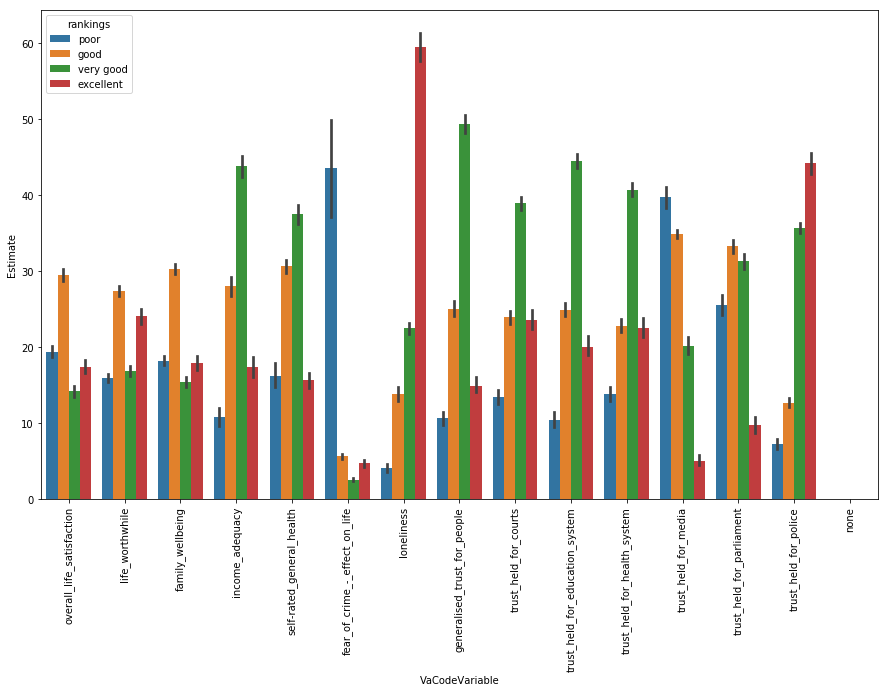

In [21]:
f, ax = plt.subplots(figsize=(15, 9))
g = sns.barplot(x='VaCodeVariable', y="Estimate", hue='rankings', data=df, hue_order=['poor', 'good', 'very good', 'excellent'])
plt.xticks(rotation=90)
plt.show()

### Create Pivot Table
Create a Pivot table, so we can retreive any CACode Mapped to any VACode without any complexity. 

In [22]:
test = df.pivot_table('Estimate', ['VaCodeVariable', 'CaCodeVariable', 'CaCodeCategory'], 'rankings')

In [23]:
new_test = test.T

### An Example

The following is an example of getting the CACode `household_income` mapped aganist the VACode `family_wellbeing`

In [24]:
fm = new_test['family_wellbeing']['household_income']

In [111]:
wellbeign_region = new_test['family_wellbeing']['region']

In [112]:
df = wellbeign_region.reset_index().T

In [113]:
df = df[1:]

In [114]:
df.drop(columns=0, inplace=True)

### Ready to Tableau Public
This Dataframe is now ready to be used in Tableau or any other charting library. 

In [115]:
df

,1,2,3,4
CaCodeCategory,,,,
auckland,16.7,33.7,16.5,16.6
bay_of_plenty,15.6,29.4,21.25,12.5
canterbury,17.3,30.8,17.7,16.5
gisborne_/_hawkes_bay,18.4,26.3,18.95,17.4
manawatu_/_whanganui,17.2,26.8,20.7,14.6
nelson/tasman/marlborough/west_coast,18.2,32.7,15.1,18.9
northland,18.4,30.4,20.7,9.9
otago,16.2,33.9,17.15,15.7
southland,21.3,28.8,15.7,18.5


In [118]:
df.rename(columns={'CaCodeCategory' : 'region', 1 : 'excellent', 2 : 'good', 3 : 'poor', 4 : 'very_good'}, inplace=True)

In [120]:
df['av_rating'] = ((((df['excellent'] / 100) * 4) + ((df['very_good'] / 100) * 3) + ((df['good'] / 100) * 2) + ((df['poor'] / 100) * 1)) / 4) * 100

In [121]:
df

,region,excellent,good,poor,very_good,av_rating
0,auckland,16.7,33.7,16.5,16.6,50.125
1,bay_of_plenty,15.6,29.4,21.25,12.5,44.9875
2,canterbury,17.3,30.8,17.7,16.5,49.5
3,gisborne_/_hawkes_bay,18.4,26.3,18.95,17.4,49.3375
4,manawatu_/_whanganui,17.2,26.8,20.7,14.6,46.725
5,nelson/tasman/marlborough/west_coast,18.2,32.7,15.1,18.9,52.5
6,northland,18.4,30.4,20.7,9.9,46.2
7,otago,16.2,33.9,17.15,15.7,49.2125
8,southland,21.3,28.8,15.7,18.5,53.5
9,taranaki,20.5,23.1,17.35,21.7,52.6625


In [123]:
df.to_json("../JSON_DATA/region_wellbeing.json", orient='table')